In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import torch
import numpy as np
import tomosipo as ts
from torch import nn
import tifffile
import xraylib

import autodiffCT.pipeline as cxpl
import autodiffCT.optimizer as ctxopt
from autodiffCT.tomography.reconstruction import PyTorchFbpOperator, fdk, fbp
from autodiffCT.tomography.phase import (PaganinPhaseRetrievalOperator, PhaseContrastOperator,
                                         retrieve_phase, simulate_refractive_attenuation,
                                         simulate_phase_contrast_images)
from autodiffCT.image.segmentation import ThresholdOperator
from autodiffCT.operator.graph import MatchScalingOperator, VoidOperator


def plot_imgs(height=5, cmap="gray", clim=(None, None), **kwargs):
    fig, axes = plt.subplots(
        nrows=1,
        ncols=len(kwargs),
        figsize=(height * len(kwargs), height)
    )
    fig.patch.set_alpha(1.0)
    if len(kwargs) == 1:
        axes = [axes]
    for ax, (k, v) in zip(axes, kwargs.items()):
        if isinstance(v, torch.Tensor):
            v = v.cpu().numpy()
        pcm = ax.imshow(v.squeeze(), cmap=cmap, clim=clim)
        fig.colorbar(pcm, ax=ax)
        ax.set_title(k)
    fig.tight_layout()
    plt.show()

/export/scratch2/schoonho/anaconda3/envs/pipeline_python310/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Create test data

Create a simple box phantom which will constitute the main material (1 voxels) and background (0 voxels). The geometry for X-ray holography is cone beam.

In [4]:
# Get date to date the saves:
from datetime import datetime
import os

date_str = datetime.today().strftime('0%Y-%m-%d')
path = 'experimental_results/'+date_str +'/'

# Meceake directory if it does not exist
folder = os.path.dirname(path)
if not os.path.exists(folder):
    os.makedirs(folder)

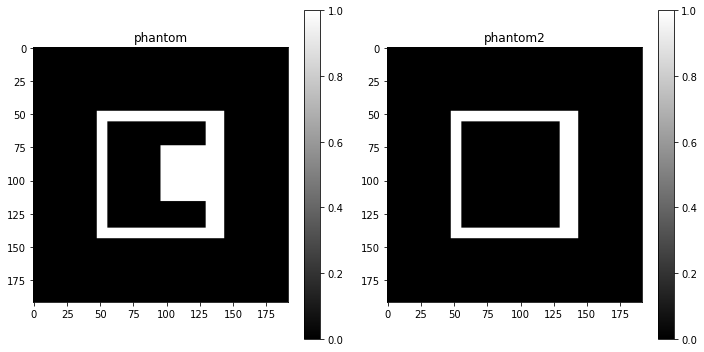

In [16]:
np.set_printoptions(precision=8)
torch.set_printoptions(precision=8)

if torch.cuda.is_available():
    dev = 'cuda'
else:
    raise Exception("No GPU available")

###  CREATE PHANTOM AND DATA  ###

# Create tomosipo geometries
vsize = 192
k = 1
vsize *= k
Angles = int(1.5*vsize) * 2

vg = ts.volume(shape=(vsize, vsize, vsize))
pg = ts.cone(angles=Angles, shape=(vsize, vsize), size=100*k, cone_angle=0.5)
A = ts.operator(vg, pg)
pg_par = ts.parallel(angles=Angles, shape=(vsize, vsize), size=vsize)
A_par = ts.operator(vg, pg_par)

# Create a phantom shape of 1s and 0s
phantom = torch.zeros(A.domain_shape, device=dev)
a1 = 48
a2 = 56
a3 = 74
a4 = 76
phantom[a1*k:vsize-a1*k, a1*k:vsize-a1*k, a1*k:vsize-a1*k] = 1.0  # box
phantom[a2*k:vsize-a2*k, a2*k:vsize-a2*k, a2*k:vsize-(a2+6)*k] = 0.0  # and hollow
phantom[a3*k:vsize-a4*k, a3*k:vsize-a4*k, (a4+20)*k:vsize-(a2+6)*k] = 1.0  # and hollow

# Choose noise level and add Poisson noise
noise_level = 200

#tifffile.imsave('temp_dir/simulated_phase_phantom.tiff', phantom.cpu().numpy()[32*k])
torch.save(phantom, path + "CaCo3_phantom.torch")
plot_imgs(phantom_im1=phantom[75*k], phantom_im2=phantom[65*k])

### Get phase projection data

To simulate phase contrast imaging, we need the attenuation and refractive index of both material. Note below how for these high energy X-rays there is little difference in refractive index. By default the background material is set to air, and the main material is set to bone (CaCO3). We then obtain phase contrast images for every angle by propagating according to the Transport of Intensity function.

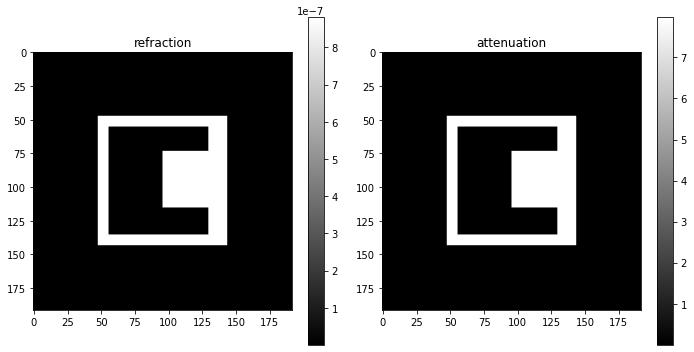

In [18]:
# NOTE: All length units must be in cm because xraylib uses this metric size
density1 = 2.71#g/cm3 CaCO3
density2 = 0.001225#g/cm3 air

#ESRF ID16a specifications https://www.esrf.fr/UsersAndScience/Experiments/XNP/ID16A
beam_energy = 25.3#keV,  ESRF ID16A has energy of 17.0-33.6 keV so we will choose middle energy.
det_pix_size = 1.1*1e-4#cm,  ESRF ID16a has two detectors with 1.1 and 1.5 microns pixel size.
propagation_dist = 15.0#cm,

mu_vol, refractive_vol, mu1, mu_bg, refraction1, refraction_bg = simulate_refractive_attenuation(phantom,
                                                                                                 compound1='CaCO3',
                                                                                                 compound2='(O2)0.209476(N2)0.78084(Ar)0.00934',
                                                                                                 beam_energy=beam_energy,
                                                                                                 density1=density1,
                                                                                                 density2=density2)
plot_imgs(refraction=refractive_vol[75*k], attenuation=mu_vol[75*k])

In [20]:
projected_thicknesses = A_par(phantom)

We can check a single forward and backward pass through the phase retrieval algorithm.

In [21]:
hc = 12.3984198 #keV * Angstrom (10^-10)                                                                                                               
beta_obj = mu1 * hc / (4*np.pi * beam_energy)
# mu is in 1/cm, hc in Amgstrom, so need to multiply by 10^8
beta_obj *= 1e-8

with torch.no_grad():
    beta_obj = torch.log(torch.tensor(beta_obj))
    refraction1 = torch.log(torch.tensor(refraction1))
    
    phase_contrast_projs = simulate_phase_contrast_images(projected_thicknesses,
                                                          beta_obj,
                                                          refraction1,
                                                          propagation_dist,
                                                          det_pix_size,
                                                          beam_energy).cpu()

In [22]:
# Simulate noise (Poisson)
phase_contrast_projs += 6*1e-4*noise_level * torch.randn(size=phase_contrast_projs.shape)*phase_contrast_projs.mean()

beta object: tensor(-19.58881760)
delta object: tensor(-13.94269180)


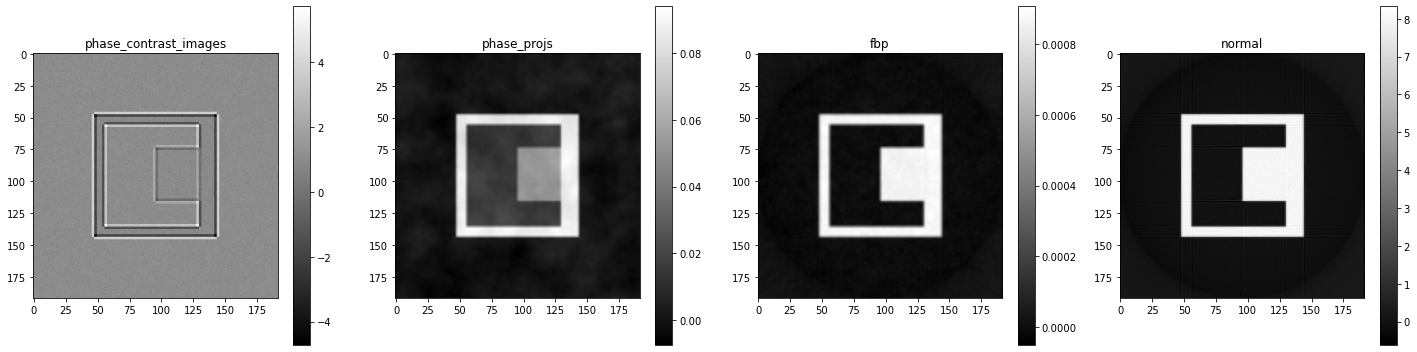

In [23]:
pixel_size = torch.tensor(det_pix_size, requires_grad=False)
b_en = torch.tensor(beam_energy, requires_grad=False)
propg_dist = torch.tensor(propagation_dist, requires_grad=False)

#K = beam_energy / (2*9.8663479e-9) # = 4 * pi * E/ (h * c)
print("beta object:", beta_obj)
print("delta object:", refraction1)


with torch.no_grad():
    phase_maps = retrieve_phase(phase_contrast_projs,
                                log_beta=beta_obj, log_delta=refraction1,
                                propg_dist=propg_dist, pixel_size=pixel_size, beam_energy=b_en)

    # Reconstruct object from projected thicknesses
    fbprec = fbp(A_par, phase_maps).cpu().detach()

    # For comparison, do normal CT scan rec with FBP
    y_par = A_par(mu_vol)
    y_par = torch.poisson(noise_level * y_par) / noise_level

# Plot results
plot_imgs(phase_contrast_images=phase_contrast_projs[0].cpu().detach(), phase_projs=phase_maps[:, 0].cpu().detach(),
          fbp=fbprec[75*k], normal=fbp(A_par, y_par)[75*k].cpu().detach())

To obtain the phase maps, we have to manually rotate the volumes every time in order to propagate the TI equation. Here, we check that indeed the projections proceed at the same angular step as if we simulate a regular parallel beam geometry of the same angular step.

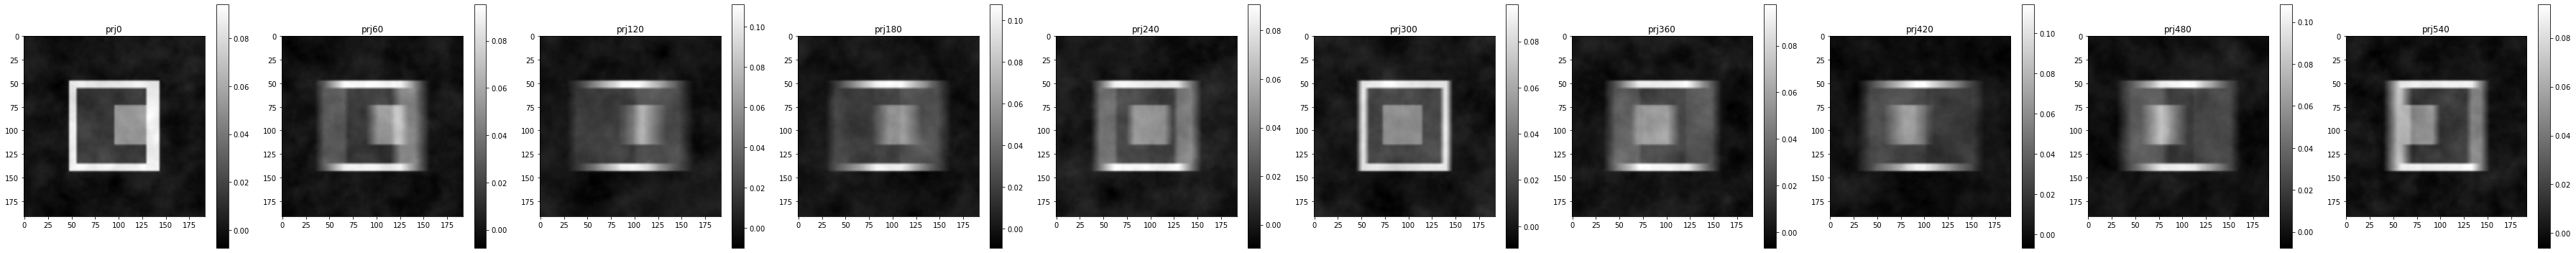

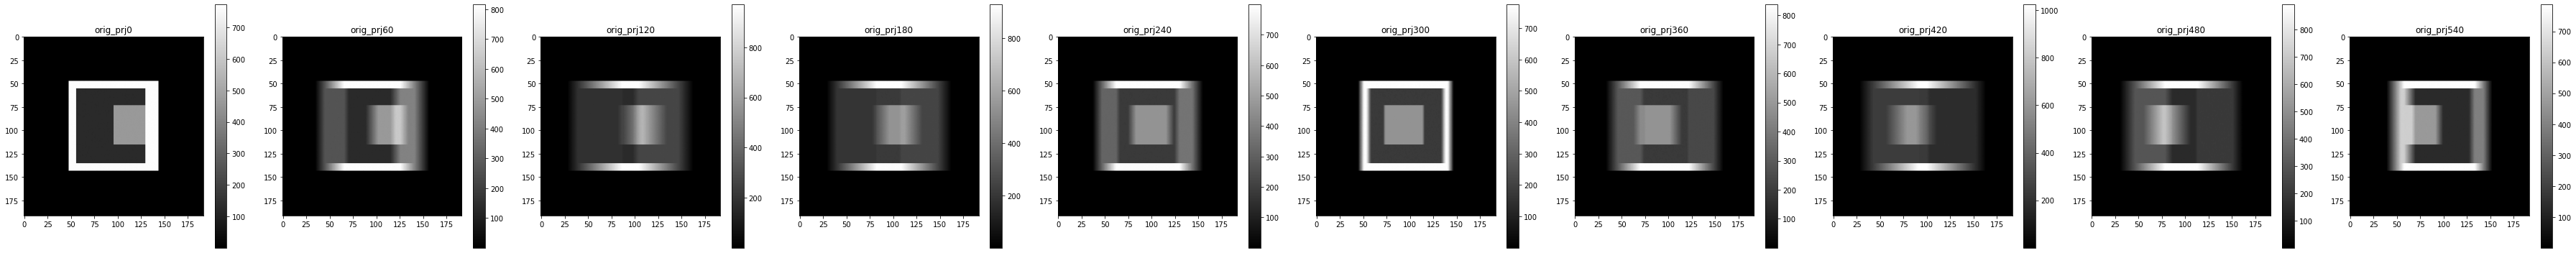

In [24]:
torch.save(phase_contrast_projs, path + "CaCo3_phase_contrast_images.torch")
torch.save(phase_maps, path + "CaCo3_phase_projections.torch")
torch.save(fbprec, path + "CaCo3_reference_fbp.torch")

plot_imgs(**{f"prj{i}": phase_maps[:,i].cpu().detach().numpy() for i in range(0, phase_maps.shape[1], 60)})
plot_imgs(**{f"orig_prj{i}": y_par[:,i].cpu().detach() for i in range(0, y_par.shape[1], 60)})

Next, we reconstruct the phase maps with FBP. This is because the retrieval algorithm already deals with the cone beam geometry. We compare with a regular parallel beam reconstruction of the same noise level. The phase retrieval algorithm creates a sharper image.

# Unsupervised fitting of beta and delta

In [25]:
delta = 1.0 - xraylib.Refractive_Index_Re(E=beam_energy, compound='H2O', density=1.0)
beta = xraylib.Refractive_Index_Im(E=beam_energy, compound='H2O', density=1.0)                          
log_delta = np.log(delta)
log_beta = np.log(beta)

In [26]:
class Logger:
    def __init__(self):
        self.betas = []
        self.deltas = []
        self.prop_dists = []
        self.pix_sizes = []
        self.beam_ens = []
    
    def log(self, optimizer_object):
        b = optimizer_object.pipeline.operators[1].parameters['log_beta']
        d = optimizer_object.pipeline.operators[1].parameters['log_delta']
        pr = optimizer_object.pipeline.operators[1].parameters['propg_dist']
        pi = optimizer_object.pipeline.operators[1].parameters['pixel_size']
        be = optimizer_object.pipeline.operators[1].parameters['beam_energy']
        self.betas.append(b.value.detach().clone().cpu())
        self.deltas.append(d.value.detach().clone().cpu())
        self.prop_dists.append(pr.value.detach().clone().cpu())
        self.pix_sizes.append(pi.value.detach().clone().cpu())
        self.beam_ens.append(be.value.detach().clone().cpu())

In [27]:
# Dataloader
device = 'cuda'

if not isinstance(log_beta, torch.Tensor):
    log_beta = torch.tensor(log_beta, requires_grad=True, device=device)
if not isinstance(log_delta, torch.Tensor):
    log_delta = torch.tensor(log_delta, requires_grad=True, device=device)

target_proj = phase_contrast_projs.clone()
target_proj = target_proj.unsqueeze(0).to(device)

dataset = torch.utils.data.TensorDataset(phase_contrast_projs.to(dev).unsqueeze(0), target_proj)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=1)

phase_retrieval_op = PaganinPhaseRetrievalOperator(A_par,
                                                   device=device,
                                                   log_beta=log_beta,
                                                   log_delta=log_delta,
                                                   propg_dist_cm=propagation_dist,
                                                   pixel_size_cm=det_pix_size,
                                                   beam_energy=beam_energy)
fbp_op = PyTorchFbpOperator(A_par, device=device)
otsu_op = ThresholdOperator(bins=256, device=device, gamma=1e3,
                            n_classes=2, split_classes=False, re_init_at_call=True, normalize=True)
with torch.no_grad():
    otsu_op.initialize_threshold(phase_contrast_projs.to(dev))

phase_proj_op = PhaseContrastOperator(projector=A_par,
                                log_beta=phase_retrieval_op.parameters['log_beta'],
                                log_delta=phase_retrieval_op.parameters['log_delta'],
                                propg_dist_cm=phase_retrieval_op.parameters['propg_dist'],
                                pixel_size_cm=phase_retrieval_op.parameters['pixel_size'],
                                beam_energy=phase_retrieval_op.parameters['beam_energy'],
                                device=device)

/ufs/schoonho/Documents/PhD/CortexPipeline/cortex_pipeline/parameter.py:45: UserWarning: Attempting to copy parameter by reference (existing parameter passed as input) but additional keyword arguments to `torch.Tensor` constructor were also specified. These will be ignored.
  warnings.warn('Attempting to copy parameter by reference '


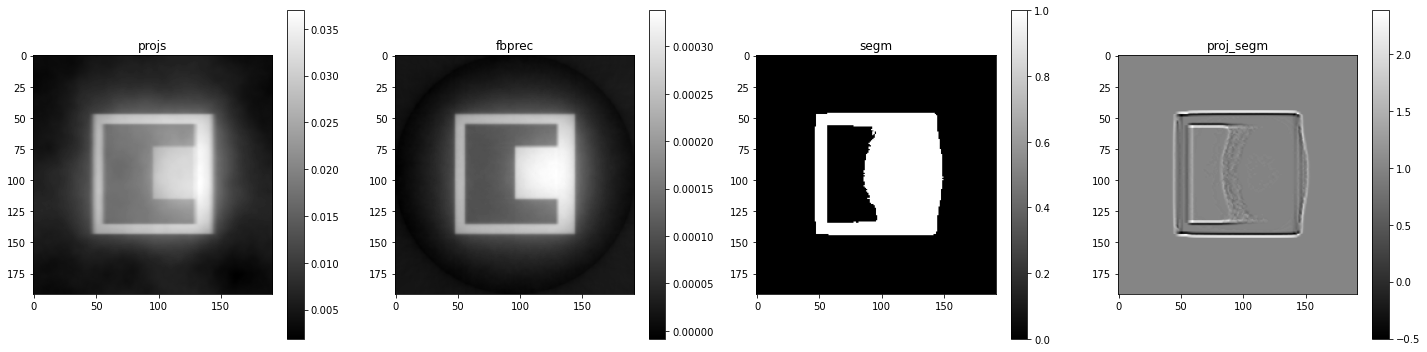

In [28]:
# This cell is to show how the wrong parameters create a wrong segmentation, which leads to
#  a wrong simulated phase contrast image.
with torch.no_grad():
    projs = phase_retrieval_op(phase_contrast_projs)
    fbprec = fbp_op(projs.unsqueeze(0))
    segm = otsu_op(fbprec)
    proj_segm = phase_proj_op(segm)

plot_imgs(projs=projs[:,10].cpu().detach(),
          fbprec=fbprec[0,75*k].cpu().detach(),
          segm=segm[0,75*k].cpu().detach(),
          proj_segm=proj_segm[0,10].cpu().detach())

In [29]:
source_op = VoidOperator()
match_scaling_op = MatchScalingOperator()

pipeline = cxpl.GraphPipeline([
    (source_op, [phase_retrieval_op, match_scaling_op]),
    (phase_retrieval_op, [fbp_op]),
    (fbp_op, [otsu_op]),
    (otsu_op, [phase_proj_op]),
    (phase_proj_op, [match_scaling_op]),
    (match_scaling_op, [])
    ]
)

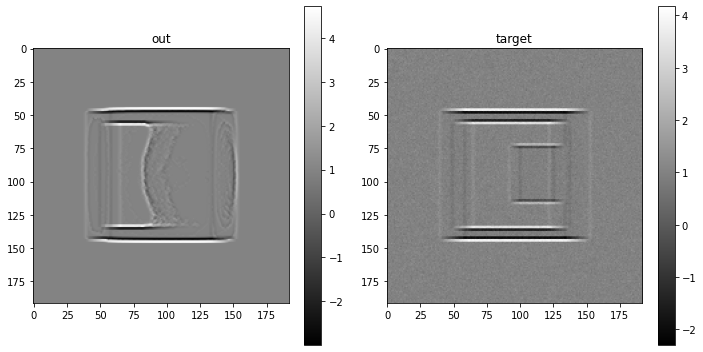

In [30]:
# This cell shows the output of the pipeline when initialized to water, and the raw input data 
#  (which is the target for this unsupervised pipeline). We will minimize the L2-loss between the two.
with torch.no_grad():
    out = pipeline(phase_contrast_projs.to(dev).unsqueeze(0))

plot_imgs(out=out[0,36*k].cpu().detach(), target=target_proj[0,36*k].cpu().detach())

In [31]:
# Define optimizer with separate learning rate:
lr = 1e-30
param_dict = {
    phase_retrieval_op: {
        'propg_dist' : 1e-30,
        'beam_energy' : 1e-30,
        'log_beta' : 3*1e-2,
        'log_delta' : 3*1e-2,
        'pixel_size' : 1e-30
    }
}
logger = Logger()
optimizer = ctxopt.PyTorchAdam(pipeline,
            target_parameters=param_dict,
            learning_rate=lr)

In [32]:
print("Starting beta:", log_beta)
print("Starting delta:", log_delta)

Starting beta: tensor(-22.36381721, device='cuda:0', requires_grad=True)
Starting delta: tensor(-14.83692551, device='cuda:0', requires_grad=True)


In [33]:
# Optimize
#torch.autograd.set_detect_anomaly(True)
niter = 120
optimal_params = optimizer.optimize(torch.nn.functional.mse_loss,
                                        data_loader=data_loader, n_iterations=niter, callback=logger.log)

100%|██████████| 120/120 [16:48<00:00,  8.40s/it]


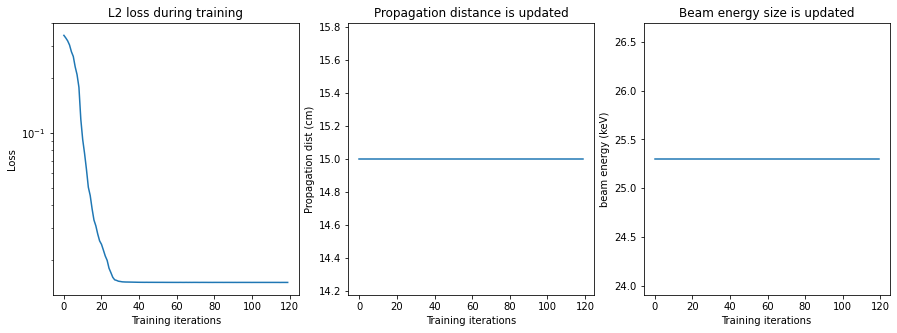

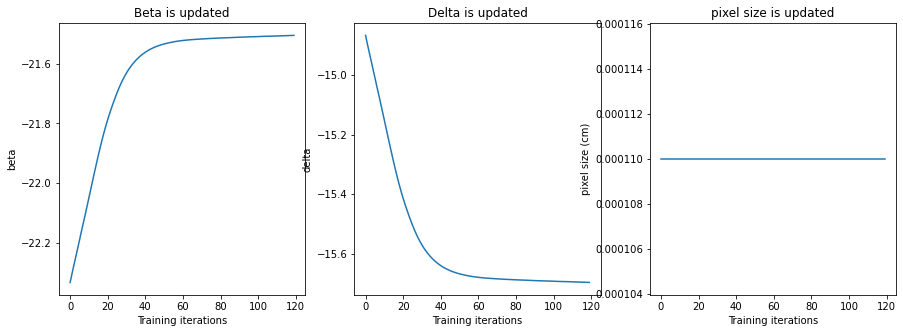

In [34]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
ax1.set_title("L2 loss during training")
ax1.plot(optimizer.losses)
ax1.set_yscale('log')
ax1.set_xlabel("Training iterations")
ax1.set_ylabel("Loss")

torch.save(torch.tensor(optimizer.losses), path + "CaCo3_losses.torch")

ax2.plot(logger.prop_dists)
ax2.set_title("Propagation distance is updated")
ax2.set_xlabel("Training iterations")
ax2.set_ylabel("Propagation dist (cm)")

ax3.plot(logger.beam_ens)
ax3.set_title("Beam energy size is updated")
ax3.set_xlabel("Training iterations")
ax3.set_ylabel("beam energy (keV)")

fig, (ax4, ax5, ax6) = plt.subplots(1, 3, figsize=(15, 5))
ax4.plot(logger.betas)
ax4.set_title("Beta is updated")
ax4.set_xlabel("Training iterations")
ax4.set_ylabel("beta")

ax5.plot(logger.deltas)
ax5.set_title("Delta is updated")
ax5.set_xlabel("Training iterations")
ax5.set_ylabel("delta")

ax6.plot(logger.pix_sizes)
ax6.set_title("pixel size is updated")
ax6.set_xlabel("Training iterations")
ax6.set_ylabel("pixel size (cm)")

torch.save(torch.tensor(logger.betas), path + "CaCo3_betas.torch")
torch.save(torch.tensor(logger.deltas), path + "CaCo3_deltas.torch")
plt.show()

In [35]:
with torch.no_grad():
    phase_maps = phase_retrieval_op(phase_contrast_projs)
    fbp_rec = fbp_op(phase_maps.unsqueeze(0))
    segm = otsu_op(fbp_rec)
    proj_segm = phase_proj_op(segm)
    out = match_scaling_op(torch.stack([phase_contrast_projs.to(dev).unsqueeze(0), proj_segm], dim=0))

print("Final pipeline loss:", torch.nn.functional.mse_loss(out, target_proj).item())

#Compare to original
delta_orig = 1.0 - xraylib.Refractive_Index_Re(E=beam_energy, compound='H2O', density=1.0)
beta_orig = xraylib.Refractive_Index_Im(E=beam_energy, compound='H2O', density=1.0)                          

with torch.no_grad():
    log_delta_orig = torch.log(torch.tensor(delta_orig)).to(device)
    log_beta_orig = torch.log(torch.tensor(beta_orig)).to(device)

    phase_retrieval_op2 = PaganinPhaseRetrievalOperator(A_par,
                                                       device=device,
                                                       log_beta=log_beta_orig,
                                                       log_delta=log_delta_orig,
                                                       propg_dist_cm=propagation_dist,
                                                       pixel_size_cm=det_pix_size,
                                                       beam_energy=beam_energy)
    phase_proj_op2 = PhaseContrastOperator(projector=A_par,
                                    log_beta=phase_retrieval_op2.parameters['log_beta'],
                                    log_delta=phase_retrieval_op2.parameters['log_delta'],
                                    propg_dist_cm=phase_retrieval_op2.parameters['propg_dist'],
                                    pixel_size_cm=phase_retrieval_op2.parameters['pixel_size'],
                                    beam_energy=phase_retrieval_op2.parameters['beam_energy'],
                                    device=device)
    phase_maps2 = phase_retrieval_op2(phase_contrast_projs)
    fbp_rec2 = fbp_op(phase_maps2.unsqueeze(0))
    segm2 = otsu_op(fbp_rec2)
    proj_segm2 = phase_proj_op(segm2)
    out2 = match_scaling_op(torch.stack([phase_contrast_projs.to(dev).unsqueeze(0), proj_segm2], dim=0))

print("Original pipeline loss:", torch.nn.functional.mse_loss(out2, target_proj).item())

Final pipeline loss: 0.0150159802287817


/ufs/schoonho/Documents/PhD/CortexPipeline/cortex_pipeline/parameter.py:45: UserWarning: Attempting to copy parameter by reference (existing parameter passed as input) but additional keyword arguments to `torch.Tensor` constructor were also specified. These will be ignored.
  warnings.warn('Attempting to copy parameter by reference '


Original pipeline loss: 0.342558890581131


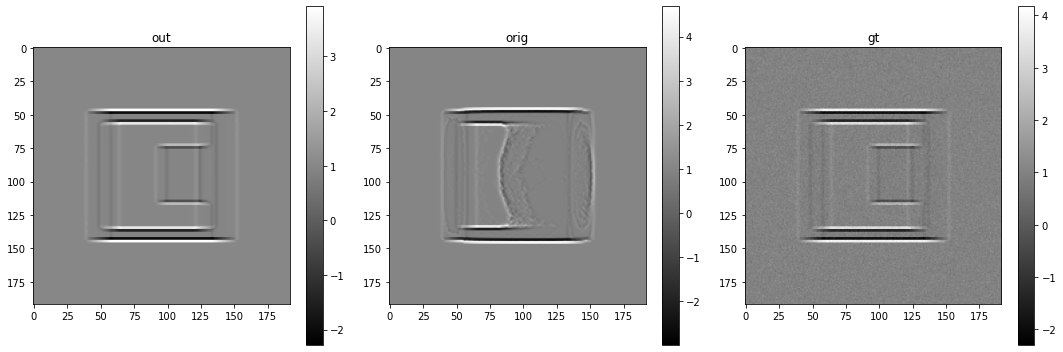

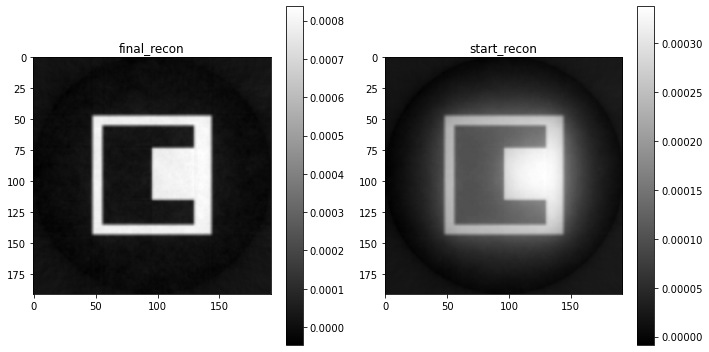

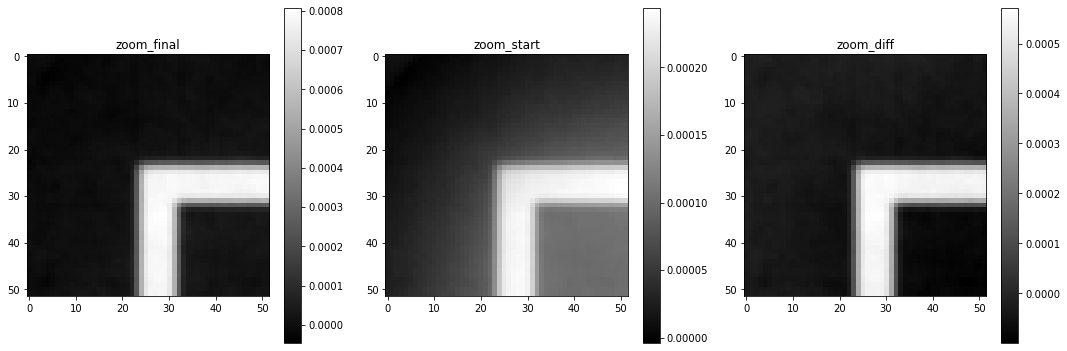

In [38]:
plot_imgs(out=out[0,36*k].detach().cpu().numpy(),
          orig=out2[0,36*k].detach().cpu().numpy(),
          gt=target_proj[0,36*k].detach().cpu().numpy(),
          #clim=[(0,3),(0,3),(0,3)]
          )

plot_imgs(final_recon=fbp_rec[0,75*k].cpu().detach(),
          start_recon=fbp_rec2[0,75*k].cpu().detach())
plot_imgs(zoom_final=fbp_rec[0,75*k,24*k:76*k,24*k:76*k].cpu().detach(),
          zoom_start=fbp_rec2[0,75*k,24*k:76*k,24*k:76*k].cpu().detach(),
          zoom_diff=(fbp_rec-fbp_rec2)[0,75*k,24*k:76*k,24*k:76*k].cpu().detach())

In [39]:
print(logger.betas[-1], logger.deltas[-1])
torch.save(fbp_rec, path + 'CaCo3_final_fbp.torch')
torch.save(fbp_rec2, path + 'CaCo3_start_fbp.torch')

tensor(-21.50493240) tensor(-15.69586849)


## Test saving and loading

In [41]:
## Test saving
pipeline.save("simulated_phase_retrieval_pipeline.pickle")

In [42]:
## Test loading
pipeline = cxpl.GraphPipeline([])
pipeline.load("simulated_phase_retrieval_pipeline.pickle")